In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro_glm.metric.models as glm_metric
import pandas as pd
import seaborn as sns
from scipy.stats import norm, t

numpyro.set_host_device_count(4)

# Chapter 19: Metric Predicted Variable with One Nominal Predictor
## Hierarchical Bayesian Approach

In [3]:
fruit_df = pd.read_csv('datasets/FruitflyDataReduced.csv')
fruit_df['CompanionNumber'] = fruit_df['CompanionNumber'].astype('category')
fruit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Longevity        125 non-null    int64   
 1   CompanionNumber  125 non-null    category
 2   Thorax           125 non-null    float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 2.4 KB


In [4]:
fruit_df.describe()

,Longevity,Thorax
count,125.000000,125.000000
mean,57.440000,0.820960
std,17.563893,0.077454
min,16.000000,0.640000
25%,46.000000,0.760000
50%,58.000000,0.840000
75%,70.000000,0.880000
max,97.000000,0.940000


Run the model.

In [5]:
key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_nominal_predictor)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    key,
    jnp.array(fruit_df['Longevity'].values),
    jnp.array(fruit_df['CompanionNumber'].cat.codes.values),
    len(fruit_df['CompanionNumber'].cat.categories))
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     57.50      7.37     57.53     46.10     69.14  12327.14      1.00
  a_grp[0]      5.69      7.69      5.60     -6.00     18.13  13256.31      1.00
  a_grp[1]      6.83      7.70      6.69     -4.86     19.31  13414.89      1.00
  a_grp[2]      5.48      7.69      5.37     -6.34     17.73  13465.07      1.00
  a_grp[3]     -0.69      7.71     -0.73    -12.55     11.66  13302.49      1.00
  a_grp[4]    -17.63      7.76    -17.42    -29.89     -5.70  13767.82      1.00
   a_sigma     14.90      7.63     13.02      5.39     24.39  21485.85      1.00
   y_sigma     14.97      0.98     14.92     13.36     16.56  42051.51      1.00

Number of divergences: 0


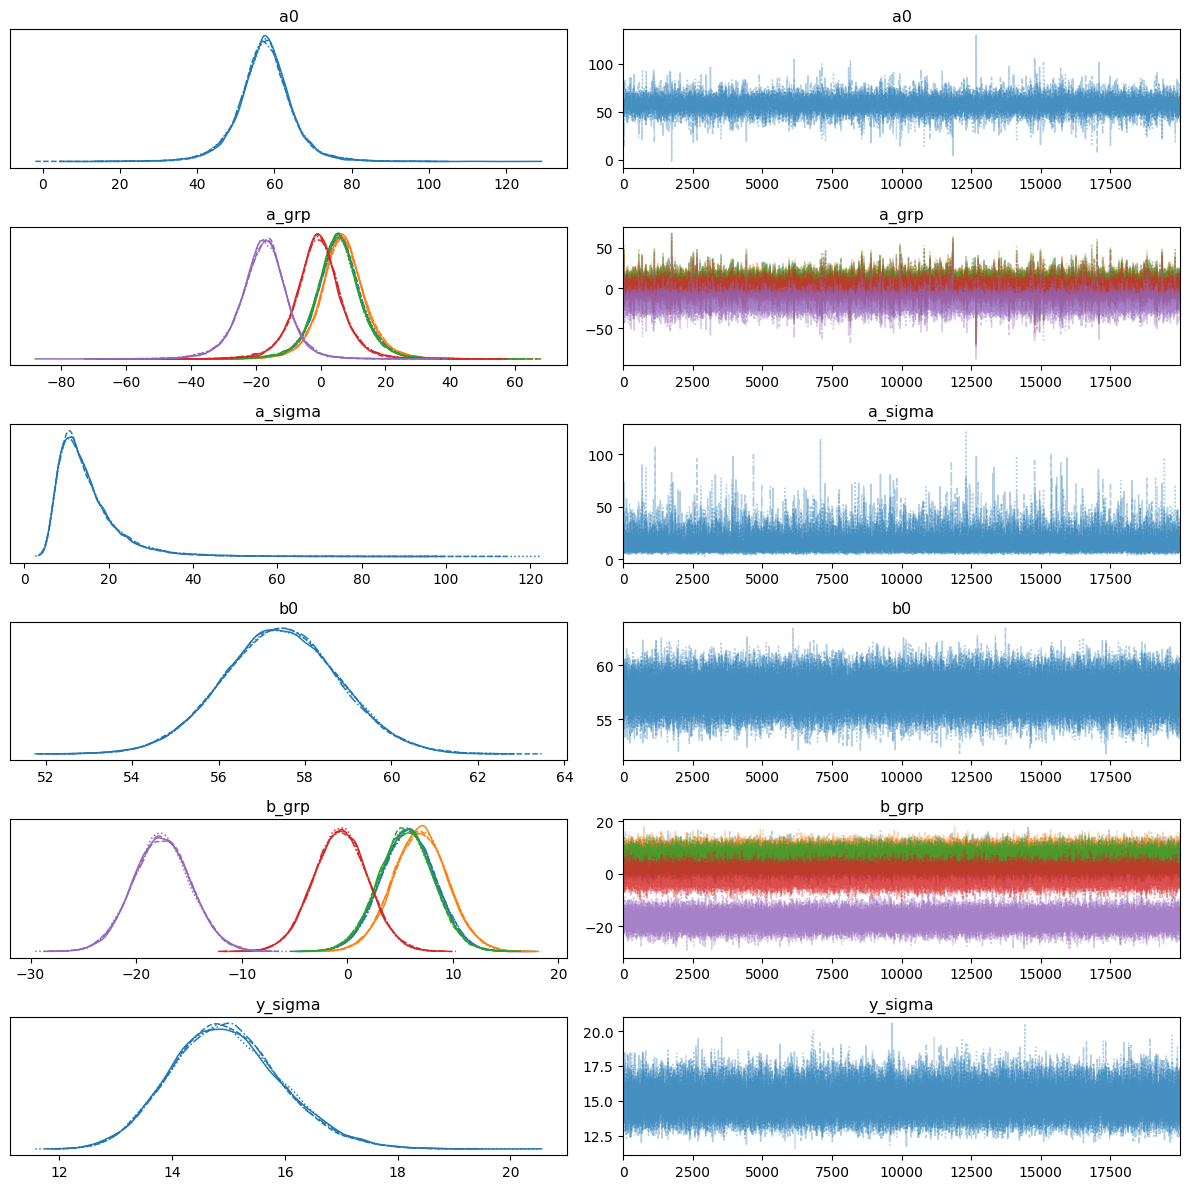

In [6]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(CompanionNumber=fruit_df['CompanionNumber'].cat.categories),
    dims=dict(b_grp=['CompanionNumber']))
az.plot_trace(idata)
plt.tight_layout()

Plot the posterior results.

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


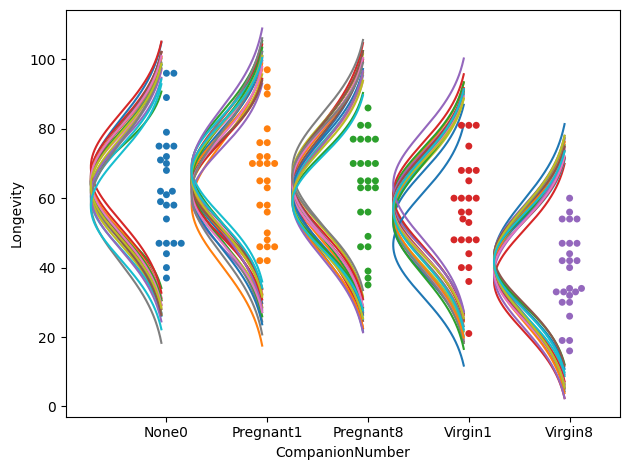

In [7]:
fig, ax = plt.subplots()
sns.swarmplot(fruit_df['CompanionNumber'], fruit_df['Longevity'], ax=ax)
ax.set_xlim(xmin=-1)

b0 = idata.posterior['b0'].values.flatten()
b_grp = {name: idata.posterior['b_grp'].sel(CompanionNumber=name).values.flatten()
         for name in fruit_df['CompanionNumber'].cat.categories}
ySigma = idata.posterior['y_sigma'].values.flatten()

n_curves = 20
for i, name in enumerate(fruit_df['CompanionNumber'].cat.categories):
    indices = np.random.choice(
        len(idata.posterior.draw) * len(idata.posterior.chain), n_curves, replace=False)

    for idx in indices:
        rv = norm(b0[idx] + b_grp[name][idx], ySigma[idx])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
        xrange = rv.pdf(yrange)

        # Scale xrange.
        xrange = xrange * 0.75 / np.max(xrange)

        # Plot the posterior.
        ax.plot(-xrange + i, yrange)

fig.tight_layout()

Plot contrasts to compare between groups.

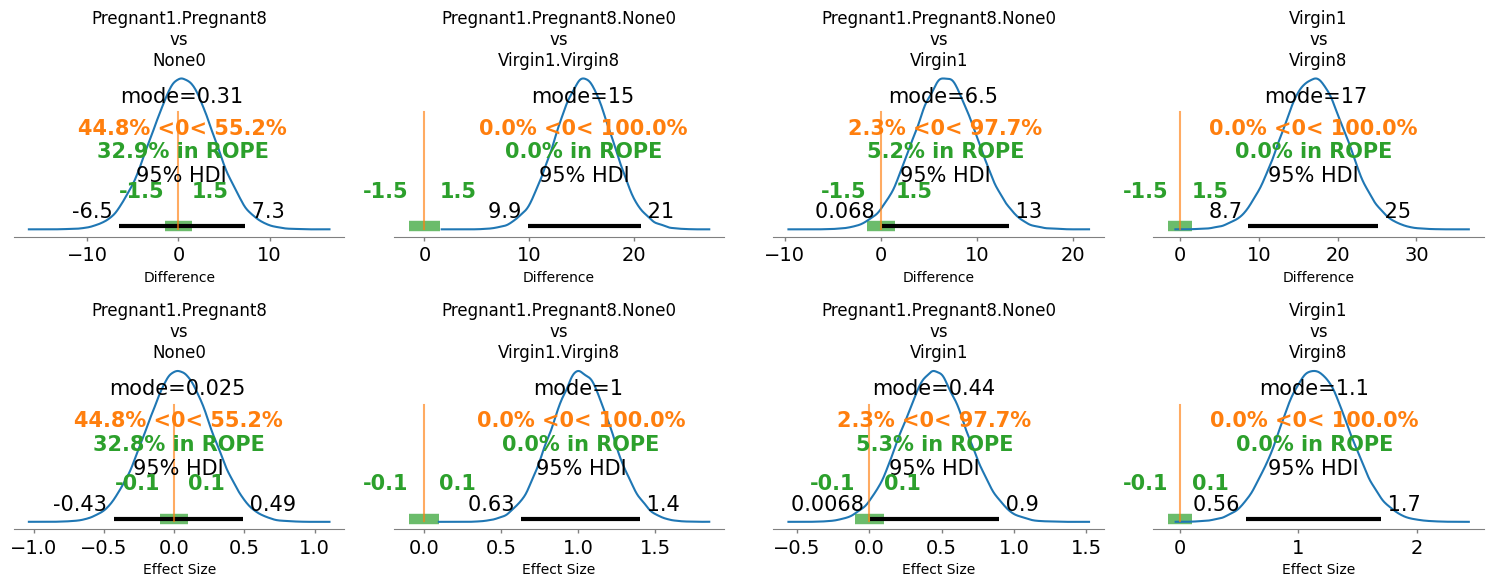

In [8]:
def plot_contrasts(idata: az.InferenceData, contrasts: 'list[dict]', b_grp_dim: str, figsize=(10, 6)):
    fig, axes = plt.subplots(nrows=2, ncols=len(contrasts), figsize=figsize)
    posterior = idata.posterior

    def mean(values: list):
        return sum(values) / len(values)

    for i, contrast in enumerate(contrasts):
        plot_title = f'{".".join(contrast["left"])}\nvs\n{".".join(contrast["right"])}'

        # Plot difference.
        ax = axes[0, i]
        left = mean([posterior['b_grp'].sel({b_grp_dim: n}).values
                     for n in contrast['left']])
        right = mean([posterior['b_grp'].sel({b_grp_dim: n}).values
                      for n in contrast['right']])
        diff = left - right

        az.plot_posterior(
            diff, hdi_prob=0.95,
            point_estimate='mode',
            ref_val=contrast['refVal'], rope=contrast['rope'],
            ax=ax)
        ax.set_title(plot_title)
        ax.set_xlabel('Difference')

        # Plot effect size.
        ax = axes[1, i]
        effSize = diff / posterior['y_sigma']

        az.plot_posterior(
            effSize, hdi_prob=0.95,
            point_estimate='mode',
            ref_val=contrast['effSizeRefVal'], rope=contrast['effSizeRope'],
            ax=ax)
        ax.set_title(plot_title)
        ax.set_xlabel('Effect Size')

    fig.tight_layout()
    return fig


contrasts = [
    dict(left=['Pregnant1', 'Pregnant8'], right=['None0'],
         refVal=0.0, rope=(-1.5, 1.5),
         effSizeRefVal=0.0, effSizeRope=(-0.1, 0.1)),
    dict(left=['Pregnant1', 'Pregnant8', 'None0'],
         right=['Virgin1', 'Virgin8'],
         refVal=0.0, rope=(-1.5, 1.5),
         effSizeRefVal=0.0, effSizeRope=(-0.1, 0.1)),
    dict(left=['Pregnant1', 'Pregnant8', 'None0'], right=['Virgin1'],
         refVal=0.0, rope=(-1.5, 1.5),
         effSizeRefVal=0.0, effSizeRope=(-0.1, 0.1)),
    dict(left=['Virgin1'], right=['Virgin8'],
         refVal=0.0, rope=(-1.5, 1.5),
         effSizeRefVal=0.0, effSizeRope=(-0.1, 0.1)),
]

_ = plot_contrasts(
    idata, contrasts, b_grp_dim='CompanionNumber', figsize=(15, 6))

## Including a Metric Predictor

In [9]:
kernel = NUTS(glm_metric.one_nominal_one_metric)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(fruit_df['Longevity'].values),
    grp=jnp.array(fruit_df['CompanionNumber'].cat.codes.values),
    cov=jnp.array(fruit_df['Thorax'].values),
    nb_groups=len(fruit_df['CompanionNumber'].cat.categories),
)
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           a0     57.55      7.07     57.48     46.79     68.46  11255.56      1.00
        a_cov    136.17     12.62    136.14    115.44    156.87  55797.89      1.00
     a_grp[0]      3.82      7.25      3.87     -7.28     15.00  11846.46      1.00
     a_grp[1]      6.37      7.26      6.39     -4.74     17.65  11878.76      1.00
     a_grp[2]      7.60      7.25      7.59     -3.21     19.03  11859.46      1.00
     a_grp[3]     -2.93      7.26     -2.84    -14.31      7.98  11844.45      1.00
     a_grp[4]    -15.38      7.28    -15.17    -26.58     -4.16  11849.57      1.00
  a_grp_sigma     13.93      7.32     12.06      5.16     22.91  18786.53      1.00
      y_sigma     10.63      0.70     10.59      9.51     11.78  45427.63      1.00

Number of divergences: 0


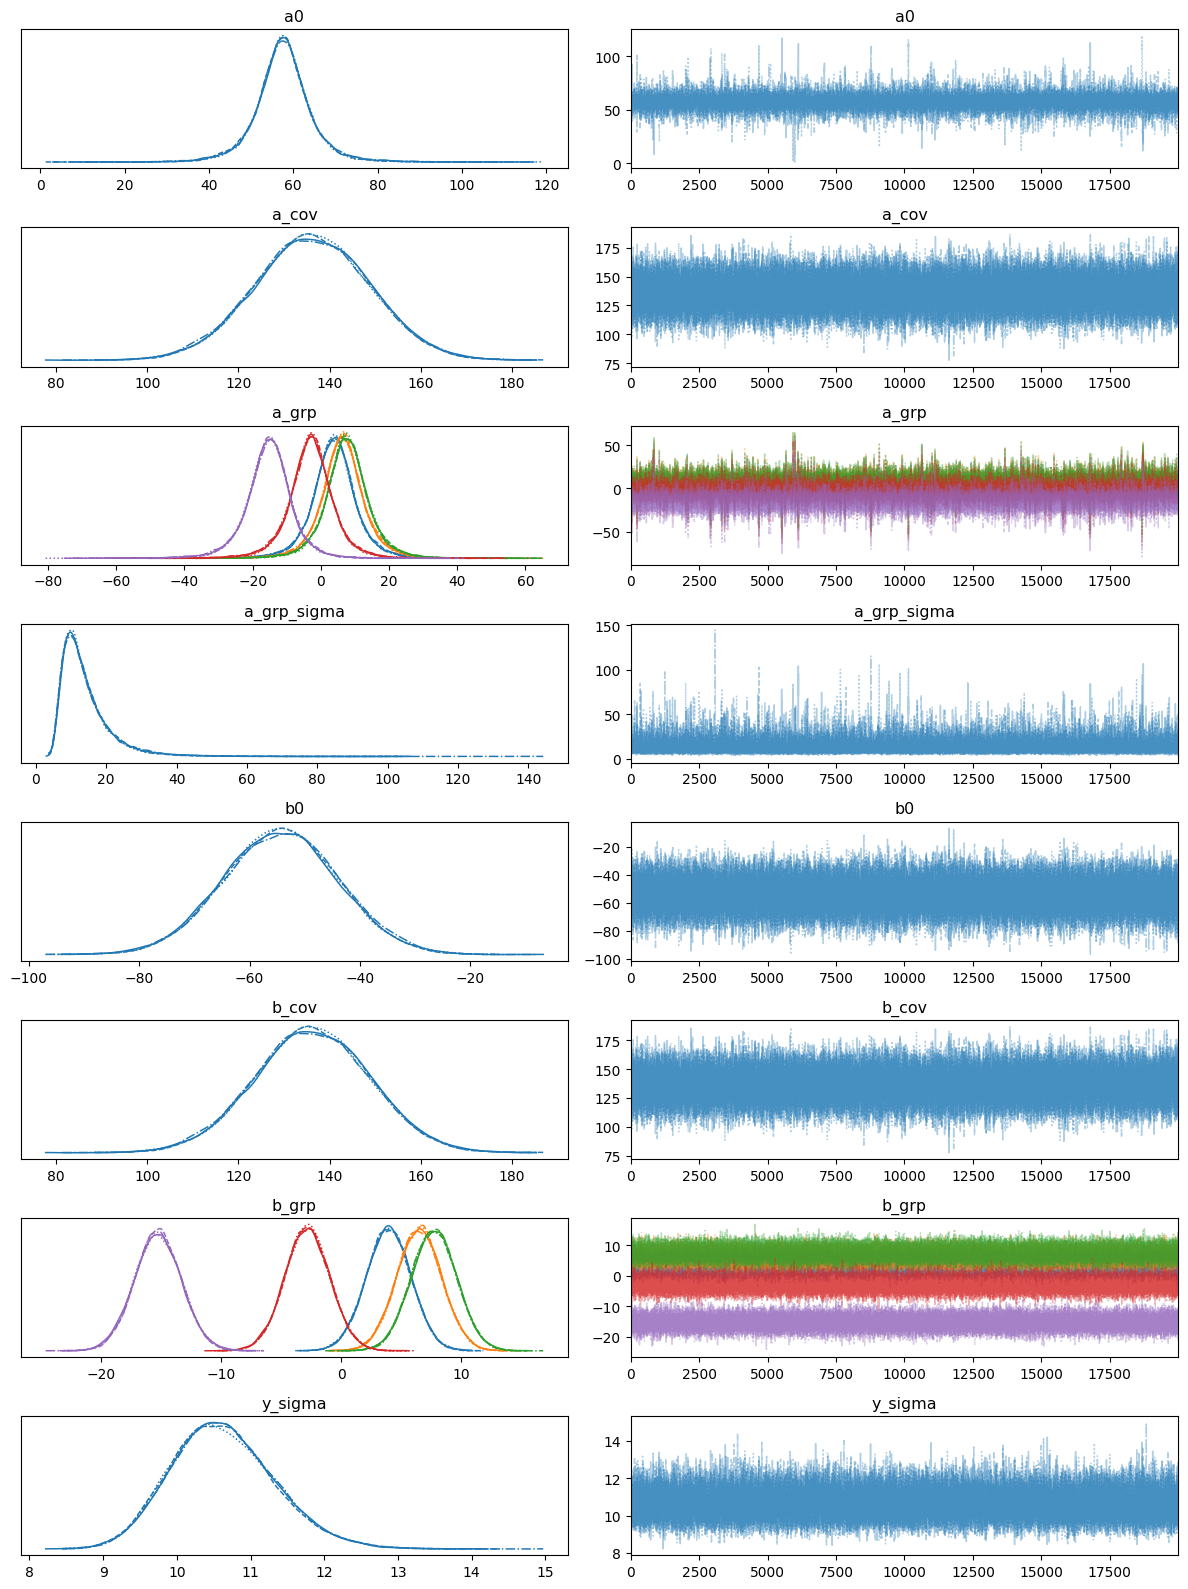

In [10]:
idata_met = az.from_numpyro(
    mcmc,
    coords=dict(CompanionNumber=fruit_df['CompanionNumber'].cat.categories),
    dims=dict(b_grp=['CompanionNumber']))
az.plot_trace(idata_met)
plt.tight_layout()

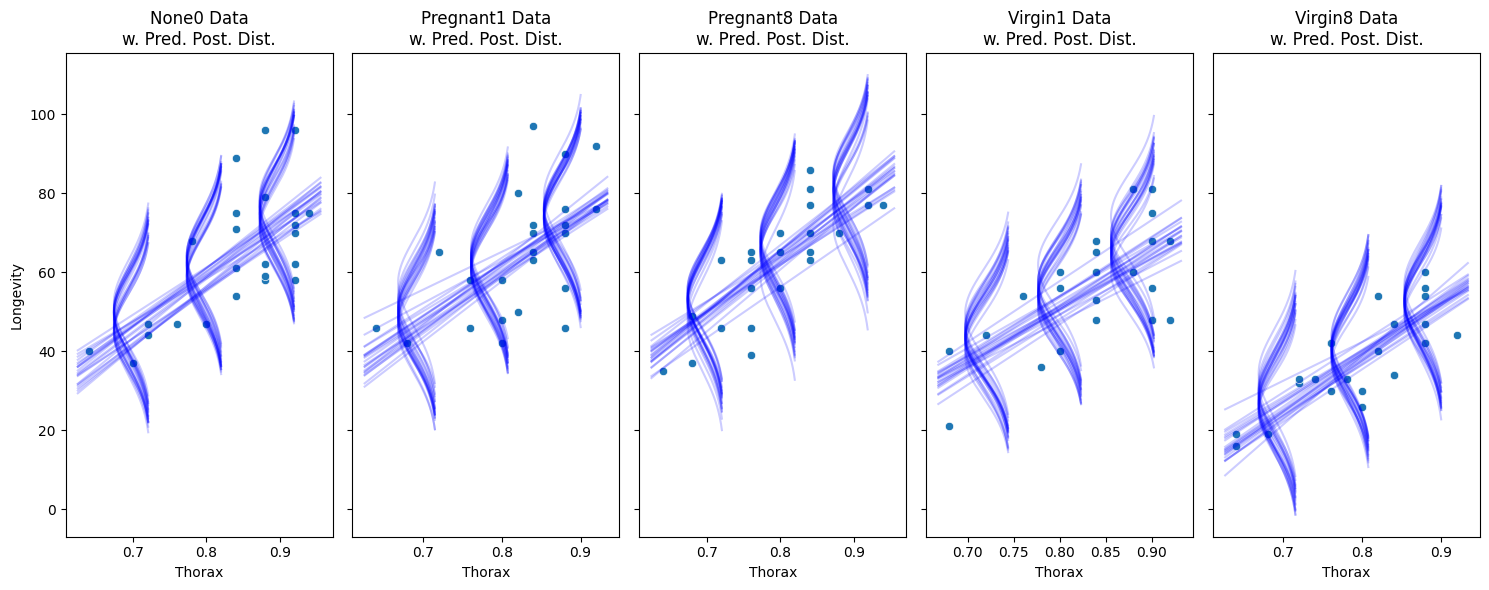

In [11]:
fig, axes = plt.subplots(
    ncols=fruit_df['CompanionNumber'].cat.categories.size,
    figsize=(15, 6),
    sharey=True)

posterior_met = idata_met.posterior
b0 = posterior_met['b0'].values.flatten()
b_cov = posterior_met['b_cov'].values.flatten()
y_sigma = posterior_met['y_sigma'].values.flatten()

n_lines = 20
for companion_nb, ax in zip(fruit_df['CompanionNumber'].cat.categories, axes.flatten()):
    data = fruit_df[fruit_df['CompanionNumber'] == companion_nb]
    sns.scatterplot(x='Thorax', y='Longevity', data=data, ax=ax)
    ax.set_title(f'{companion_nb} Data\nw. Pred. Post. Dist.')

    xrange = np.linspace(*ax.get_xlim(), 1000)

    line_indices = np.random.choice(
        posterior_met.draw.size * posterior_met.chain.size,
        n_lines,
        replace=False)

    b_grp = posterior_met['b_grp'].sel(
        CompanionNumber=companion_nb).values.flatten()

    for idx in line_indices:
        y = b0[idx] + b_grp[idx] + xrange * b_cov[idx]
        ax.plot(xrange, y, c='b', alpha=.2)

        # Plot predicted posterior distribution of Longevity|Thorax.
        for xidx in [300, 600, 900]:
            rv = norm(y[xidx], y_sigma[idx])
            yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
            xpdf = rv.pdf(yrange)

            # Scale the pdf.
            xpdf = xpdf * 0.05 / np.max(xpdf)

            # Plot the distribution.
            ax.plot(xrange[xidx] - xpdf, yrange, c='b', alpha=.2)

fig.tight_layout()

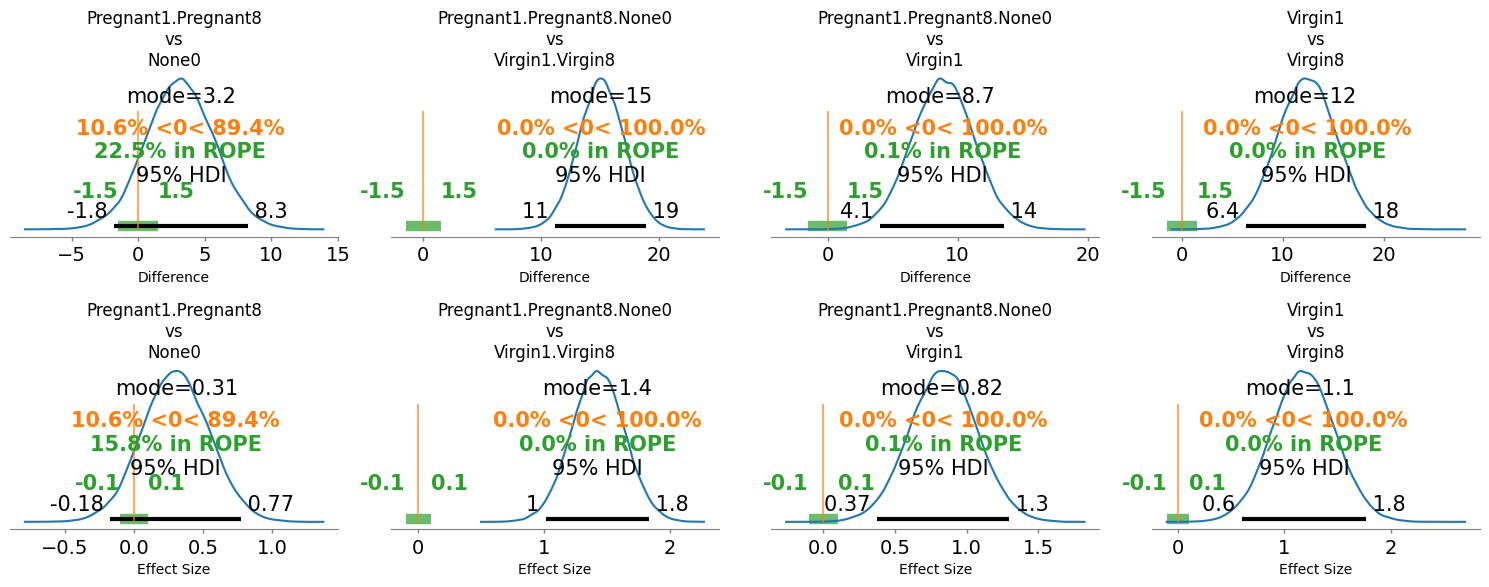

In [12]:
_ = plot_contrasts(idata_met, contrasts,
                   b_grp_dim='CompanionNumber', figsize=(15, 6))

## Heterogeneous Variances and Robustness against Outliers

In [13]:
nonhomo_df = pd.read_csv('datasets/NonhomogVarData.csv')
nonhomo_df['Group'] = nonhomo_df['Group'].astype('category')
nonhomo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Group   96 non-null     category
 1   Y       96 non-null     float64 
dtypes: category(1), float64(1)
memory usage: 1.2 KB


<Axes: xlabel='Group', ylabel='Y'>

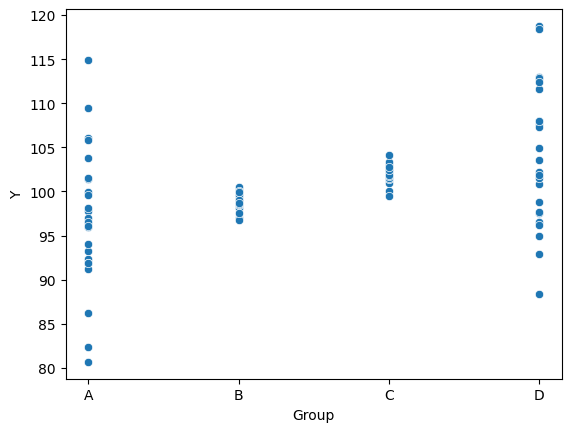

In [14]:
sns.scatterplot(x='Group', y='Y', data=nonhomo_df)

### Homogeneous Model

In [15]:
kernel = NUTS(glm_metric.one_nominal_predictor)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(nonhomo_df['Y'].values),
    grp=jnp.array(nonhomo_df['Group'].cat.codes.values),
    nb_groups=nonhomo_df['Group'].cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0    100.50      2.97    100.49     96.11    104.87   8658.64      1.00
  a_grp[0]     -3.10      3.09     -2.98     -7.85      1.30   9309.88      1.00
  a_grp[1]     -1.33      3.08     -1.27     -5.91      3.30   9346.19      1.00
  a_grp[2]      1.33      3.08      1.26     -3.15      6.01   9347.58      1.00
  a_grp[3]      3.11      3.09      2.98     -1.41      7.75   9407.26      1.00
   a_sigma      4.90      3.40      3.96      1.04      8.93  12655.42      1.00
   y_sigma      5.78      0.43      5.76      5.07      6.47  40793.72      1.00

Number of divergences: 0


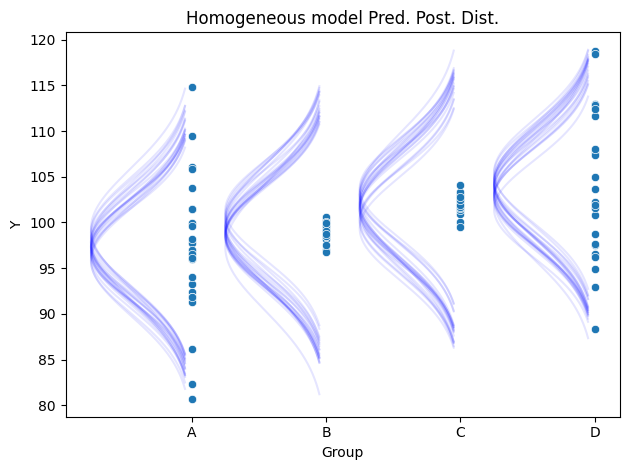

In [16]:
idata_hom = az.from_numpyro(
    mcmc,
    coords=dict(Group=nonhomo_df['Group'].cat.categories.values),
    dims=dict(b_grp=['Group']))
posterior_hom = idata_hom.posterior

b0 = posterior_hom['b0'].values.flatten()
y_sigma = posterior_hom['y_sigma'].values.flatten()

fig, ax = plt.subplots()
sns.scatterplot(x='Group', y='Y', data=nonhomo_df, ax=ax)
ax.set_title(f'Homogeneous model Pred. Post. Dist.')

n_curves = 20
for gid, group in enumerate(nonhomo_df['Group'].cat.categories):
    curve_indices = np.random.choice(
        posterior_hom.draw.size * posterior_hom.chain.size, n_curves, replace=False)

    b_grp = posterior_hom['b_grp'].sel(Group=group).values.flatten()

    for idx in curve_indices:
        mean = b0[idx] + b_grp[idx]
        sigma = y_sigma[idx]
        rv = norm(mean, sigma)

        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
        xpdf = rv.pdf(yrange)

        # Scale pdf to be superimposed on scatterplot.
        xpdf = xpdf * 0.75 / np.max(xpdf)

        # Plot the resulting posterior dist.
        ax.plot(gid - xpdf, yrange, c='b', alpha=0.1)

fig.tight_layout()

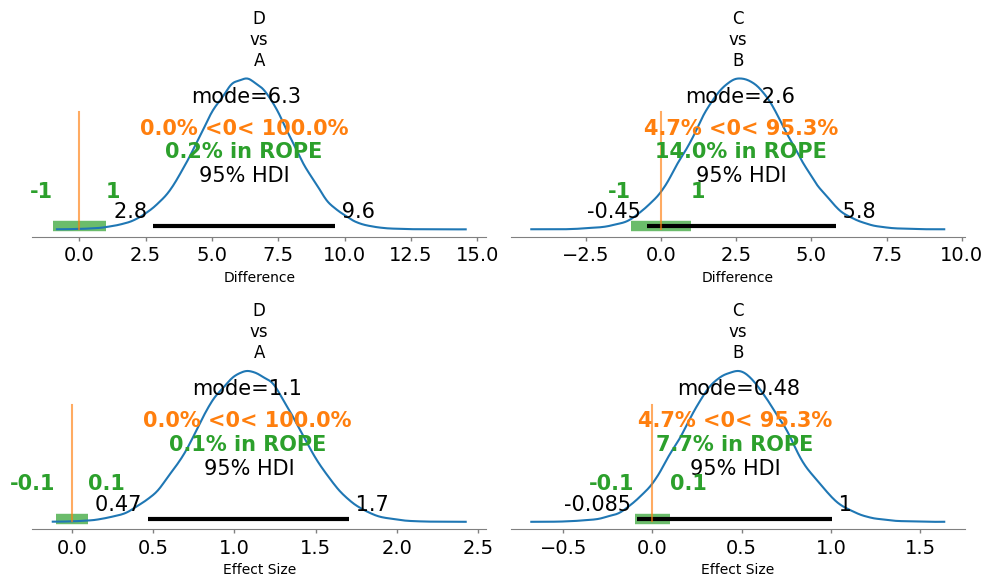

In [17]:
contrasts = [
    dict(left=['D'], right=['A'],
         refVal=0, rope=(-1, 1),
         effSizeRefVal=0, effSizeRope=(-0.1, 0.1)),
    dict(left=['C'], right=['B'],
         refVal=0, rope=(-1, 1),
         effSizeRefVal=0, effSizeRope=(-0.1, 0.1)),
]
_ = plot_contrasts(idata_hom, contrasts, b_grp_dim='Group')

### Heterogeneous Model

In [18]:
kernel = NUTS(glm_metric.one_nominal_predictor_het_var_robust)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(nonhomo_df['Y'].values),
    grp=jnp.array(nonhomo_df['Group'].cat.codes.values),
    nb_groups=nonhomo_df['Group'].cat.categories.size,
)
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
            a0    100.44      2.86    100.50     96.30    104.62   7586.52      1.00
      a_grp[0]     -2.69      3.09     -2.54     -7.52      1.60   9033.74      1.00
      a_grp[1]     -1.41      2.86     -1.46     -5.72      2.60   7636.50      1.00
      a_grp[2]      1.57      2.86      1.50     -2.61      5.71   7614.35      1.00
      a_grp[3]      2.75      3.12      2.50     -1.71      7.43   8919.18      1.00
   a_grp_sigma      4.56      3.27      3.66      0.96      8.33  12846.36      1.00
            nu     34.47     29.82     25.40      2.76     73.36  58366.91      1.00
    y_sigma[0]      7.77      1.32      7.65      5.67      9.87  56503.73      1.00
    y_sigma[1]      1.02      0.18      1.00      0.74      1.30  54662.35      1.00
    y_sigma[2]      1.00      0.18      0.98      0.71      1.28  55233.15      1.00
    y_sigma[3]      7.91      1.29      7.77      5.86      9.94

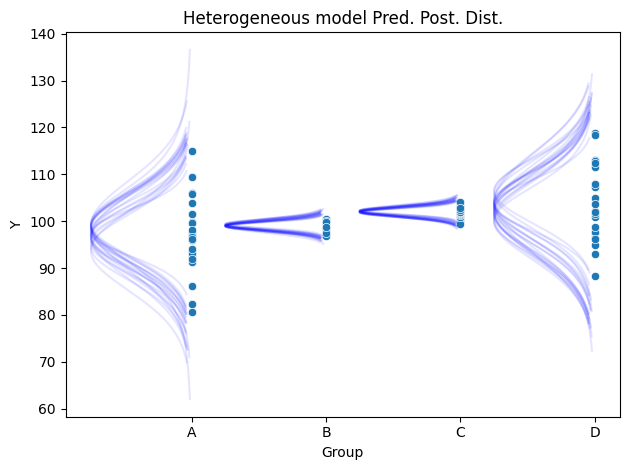

In [19]:
idata_het = az.from_numpyro(
    mcmc,
    coords=dict(Group=nonhomo_df['Group'].cat.categories.values),
    dims=dict(b_grp=['Group'], y_sigma=['Group']))
posterior_het = idata_het.posterior

b0 = posterior_het['b0'].values.flatten()
nu = posterior_het['nu'].values.flatten()

fig, ax = plt.subplots()
sns.scatterplot(x='Group', y='Y', data=nonhomo_df, ax=ax)
ax.set_title(f'Heterogeneous model Pred. Post. Dist.')

n_curves = 20
for gid, group in enumerate(nonhomo_df['Group'].cat.categories):
    curve_indices = np.random.choice(
        posterior_het.draw.size * posterior_het.chain.size, n_curves, replace=False)

    b_grp = posterior_het['b_grp'].sel(Group=group).values.flatten()
    y_sigma = posterior_het['y_sigma'].sel(Group=group).values.flatten()

    for idx in curve_indices:
        mean = b0[idx] + b_grp[idx]
        sigma = y_sigma[idx]
        rv = t(nu[idx], mean, sigma)

        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
        xpdf = rv.pdf(yrange)

        # Scale pdf to be superimposed on scatterplot.
        xpdf = xpdf * 0.75 / np.max(xpdf)

        # Plot the resulting posterior dist.
        ax.plot(gid - xpdf, yrange, c='b', alpha=0.1)

fig.tight_layout()

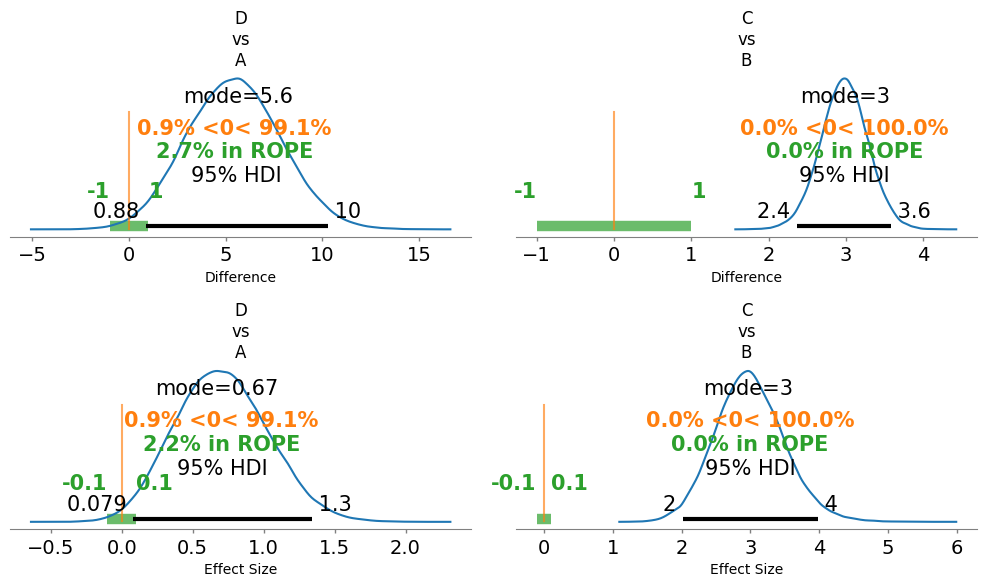

In [20]:
def plot_contrasts_het(idata: az.InferenceData, contrasts: 'list[dict]', figsize=(10, 6)):
    fig, axes = plt.subplots(nrows=2, ncols=len(contrasts), figsize=figsize)
    posterior = idata.posterior

    def mean(values: list):
        return sum(values) / len(values)

    for i, contrast in enumerate(contrasts):
        plot_title = f'{".".join(contrast["left"])}\nvs\n{".".join(contrast["right"])}'

        # Plot difference.
        ax = axes[0, i]
        left = mean([posterior['b_grp'].sel(Group=n).values
                     for n in contrast['left']])
        right = mean([posterior['b_grp'].sel(Group=n).values
                      for n in contrast['right']])
        diff = left - right

        az.plot_posterior(
            diff, hdi_prob=0.95,
            point_estimate='mode',
            ref_val=contrast['refVal'], rope=contrast['rope'],
            ax=ax)
        ax.set_title(plot_title)
        ax.set_xlabel('Difference')

        # Plot effect size.
        ax = axes[1, i]
        y_sigma_sq = mean([posterior['y_sigma'].sel(Group=n).values**2
                          for n in (contrast['left'] + contrast['right'])])
        effSize = diff / np.sqrt(y_sigma_sq)

        az.plot_posterior(
            effSize, hdi_prob=0.95,
            point_estimate='mode',
            ref_val=contrast['effSizeRefVal'], rope=contrast['effSizeRope'],
            ax=ax)
        ax.set_title(plot_title)
        ax.set_xlabel('Effect Size')

    fig.tight_layout()
    return fig


_ = plot_contrasts_het(idata_het, contrasts)